In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import os

In [2]:
# For using Google Colab only
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


base_path = '/content/drive/MyDrive/Data'

# Trade data
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_Australia.xlsx'
trade_australia = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_Canada.xlsx'
trade_canada = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_China.xlsx'
trade_china = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_United_Kingdom.xlsx'
trade_uk = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_United_States_of_America.xlsx'
trade_usa = pd.read_excel(trade_path, skiprows=4, header=[0, 1])

# Economic indicators
changing_scenarios = pd.read_excel('/content/drive/MyDrive/Data/Copy of changing scenerio.xlsx')


# Specify the folder path for economic data (only once)
economic_path = '/content/drive/MyDrive/Data/Data2/GDP etc/'

# Read the 'Expense.xlsx' file
expense = pd.read_excel(economic_path + 'Expense.xlsx', skiprows=4, header=[0, 1])
gdp_growth = pd.read_excel(economic_path + 'GDP growth.xlsx', skiprows=4, header=[0, 1])
inflation = pd.read_excel(economic_path + 'Inflation.xlsx', skiprows=4, header=[0, 1])
net_investment = pd.read_excel(economic_path + 'Net investment.xlsx', skiprows=4, header=[0, 1])

# Specify the folder path for import trade data (only once)
import_path = '/content/drive/MyDrive/Data/Data2/Import and Import from world/'

# Read the 'Import Trade_between_United_Arab_Emirates_and_Canada.xlsx' file
import_trade_canada = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Canada.xlsx', skiprows=4, header=[0, 1])
import_trade_china = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_China.xlsx', skiprows=4, header=[0, 1])
import_trade_india = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_India.xlsx', skiprows=4, header=[0, 1])
import_trade_uk = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Unites_Kingdom.xlsx', skiprows=4, header=[0, 1])
import_trade_usa = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Unites_State_of_America.xlsx', skiprows=4, header=[0, 1])

In [58]:
trade_usa.head()

Product code                                      Product label  \
  Unnamed: 0_level_1                                 Unnamed: 1_level_1   
0             'TOTAL                                       All products   
1                '01                                       Live animals   
2                '02                         Meat and edible meat offal   
3                '03  Fish and crustaceans, molluscs and other aquat...   
4                '04  Dairy produce; birds' eggs; natural honey; edi...   

  United Arab Emirates's exports to United States of America                \
                                               Value in 2003 Value in 2004   
0                                                NaN                   NaN   
1                                                NaN                   NaN   
2                                                NaN                   NaN   
3                                                NaN                   NaN   
4                                                NaN                   NaN   

                                                                         \
  Value in 2005 Value in 2006 Value in 2007 Value in 2008 Value in 2009   
0        796518           NaN        699712       1230163           NaN   
1           246           NaN            20            27           NaN   
2            52           NaN           122            62           NaN   
3         20507           NaN         11214          4646           NaN   
4           379           NaN           134           267           NaN   

                 ... United Arab Emirates's exports to world                \
  Value in 2010  ...                           Value in 2013 Value in 2014   
0           NaN  ...                               371217682     343043070   
1           NaN  ...                                   59638        359214   
2           NaN  ...                                   81831         66076   
3           NaN  ...                                  128652        114418   
4           NaN  ...                                  374787        439388   

                                                                         \
  Value in 2015 Value in 2016 Value in 2017 Value in 2018 Value in 2019   
0     300478648     295046691     313547597     321006905     315942728   
1         57364         46087         42979         90455         56361   
2         49031         53463         70800        244690        652931   
3        114360        123412         76224        212978        190332   
4        642173        470889        539346        945655        988080   

                                             
  Value in 2020 Value in 2021 Value in 2022  
0     335296908     425159797     311313710  
1         42405         30095         23998  
2        258430        357568         28133  
3        140263        132971        234334  
4        881124        945101         84495  

[5 rows x 64 columns]

In [4]:
trade_usa.shape

(98, 64)

In [57]:
second_column = import_trade_usa.iloc[:, 1]  # Index 1 corresponds to the second column
print(second_column)

0                                          All products
1                                          Live animals
2                            Meat and edible meat offal
3     Fish and crustaceans, molluscs and other aquat...
4     Dairy produce; birds' eggs; natural honey; edi...
                            ...                        
93    Furniture; bedding, mattresses, mattress suppo...
94    Toys, games and sports requisites; parts and a...
95                  Miscellaneous manufactured articles
96        Works of art, collectors' pieces and antiques
97                  Commodities not elsewhere specified
Name: (Product label, Unnamed: 1_level_1), Length: 98, dtype: object


In [5]:
def clean_trade_data(df):
    # Drop rows with NaN values in the first 5 columns
    df = df.dropna(subset=df.columns[:5], how='all')

    # Rename columns
    df.columns = [' '.join(map(str, col)).strip() if 'Unnamed' not in col else str(col[0]) for col in df.columns.values]

    # Simplify column names
    new_columns = []
    for col in df.columns:
        if 'Value in' in col:
            new_columns.append(col.split()[-1])  # Just the year
        elif 'Product code' in col:
            new_columns.append('Product Code')
        elif 'Product label' in col:
            new_columns.append('Product Label')
        else:
            new_columns.append(col)  # The first part of the tuple
    df.columns = new_columns

    # Drop columns and rows that are completely NaN
    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df


In [13]:
df=clean_trade_data(import_trade_india)  # selecting desired import ,export country

In [581]:
df.head()

,Product Code,Product Label,2005,2007,2008,2012,2013,2014,2015,2016,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,'TOTAL,All products,8765235,12247038,16873675,25533300,19898118,17429079,17859649,18669359,...,294955904,298608729,287024695,270779149,273710850,261510757,267937296,246961071,347528998,248626440
1,'01,Live animals,752,7491,8080,20846,19317,53561,59463,51283,...,238531,269309,288170,204226,195582,114961,115420,109286,124123,117418
2,'02,Meat and edible meat offal,48159,120842,155358,197077,195931,192753,193580,188893,...,1572532,1590308,1663314,1626971,1705968,1870160,2281642,1752583,2030354,2405744
3,'03,"Fish and crustaceans, molluscs and other aquat...",20221,65868,64377,104589,82883,167023,140980,159615,...,438378,575996,514124,552588,617538,649060,647939,590170,647185,503421
4,'04,Dairy produce; birds' eggs; natural honey; edi...,31053,24339,48175,29276,38291,45251,34315,32964,...,1463353,1778903,1588084,1438793,1816500,1851023,1726308,1747003,1730067,1322676


In [14]:
# dropping product code column
df = df.drop(df.columns[0], axis=1)

In [583]:
df.head()

,Product Label,2005,2007,2008,2012,2013,2014,2015,2016,2017,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,All products,8765235,12247038,16873675,25533300,19898118,17429079,17859649,18669359,20232077,...,294955904,298608729,287024695,270779149,273710850,261510757,267937296,246961071,347528998,248626440
1,Live animals,752,7491,8080,20846,19317,53561,59463,51283,44014,...,238531,269309,288170,204226,195582,114961,115420,109286,124123,117418
2,Meat and edible meat offal,48159,120842,155358,197077,195931,192753,193580,188893,182847,...,1572532,1590308,1663314,1626971,1705968,1870160,2281642,1752583,2030354,2405744
3,"Fish and crustaceans, molluscs and other aquat...",20221,65868,64377,104589,82883,167023,140980,159615,203497,...,438378,575996,514124,552588,617538,649060,647939,590170,647185,503421
4,Dairy produce; birds' eggs; natural honey; edi...,31053,24339,48175,29276,38291,45251,34315,32964,38854,...,1463353,1778903,1588084,1438793,1816500,1851023,1726308,1747003,1730067,1322676


In [15]:
# selecting desired product by index
df=df.iloc[1]

In [585]:
df.head()

Product Label    Live animals
2005                      752
2007                     7491
2008                     8080
2012                    20846
Name: 1, dtype: object

In [586]:
print(df)

Product Label    Live animals
2005                      752
2007                     7491
2008                     8080
2012                    20846
2013                    19317
2014                    53561
2015                    59463
2016                    51283
2017                    44014
2018                    25342
2019                    27837
2020                    16517
2021                    10095
2003                     3949
2004                     5828
2005                     5081
2006                     9798
2007                     9431
2008                    10760
2009                    17902
2010                    12256
2011                    13153
2012                     6179
2013                    12504
2014                    12533
2015                     9953
2016                    37137
2017                    27113
2018                    31314
2019                    16861
2020                     5350
2021                    10804
2022      

In [16]:
# Remove the title rows without affecting the columns
df = df.iloc[2:]

In [17]:
df=pd.DataFrame(df)

In [589]:
df.head()

,1
2007,7491
2008,8080
2012,20846
2013,19317
2014,53561


In [18]:
# selecting first 12 rows since after that data is for import or export to world
df = df.iloc[:12]

print(df)

          1
2007   7491
2008   8080
2012  20846
2013  19317
2014  53561
2015  59463
2016  51283
2017  44014
2018  25342
2019  27837
2020  16517
2021  10095


<Axes: >

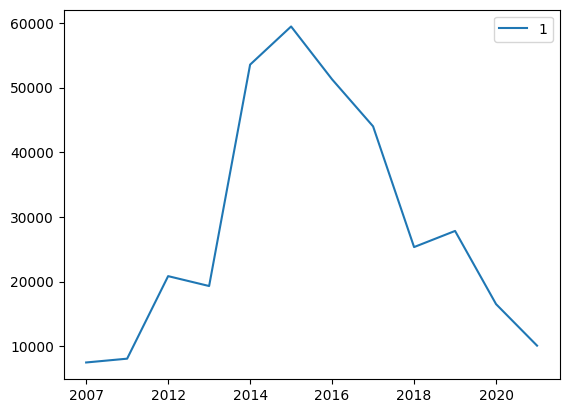

In [591]:
df.plot()

In [19]:

# Convert the years column to a datetime index and set the column name as 'Date'
df.index = pd.to_datetime(df.index, format='%Y')
df.index.name = 'Date'

print(df)


                1
Date             
2007-01-01   7491
2008-01-01   8080
2012-01-01  20846
2013-01-01  19317
2014-01-01  53561
2015-01-01  59463
2016-01-01  51283
2017-01-01  44014
2018-01-01  25342
2019-01-01  27837
2020-01-01  16517
2021-01-01  10095


In [20]:
df = df.rename(columns={1: 'Values'})

In [594]:
df.head()

,Values
Date,
2007-01-01,7491
2008-01-01,8080
2012-01-01,20846
2013-01-01,19317
2014-01-01,53561


In [595]:
df.to_csv('output.csv', index=False)

<Axes: xlabel='Date'>

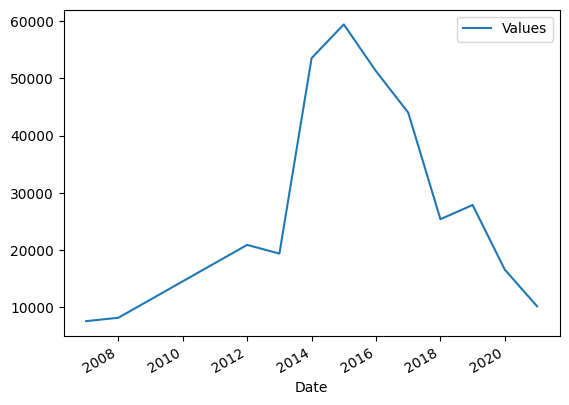

In [596]:
df.plot()

In [597]:


df=pd.read_csv('output.csv')

<Axes: >

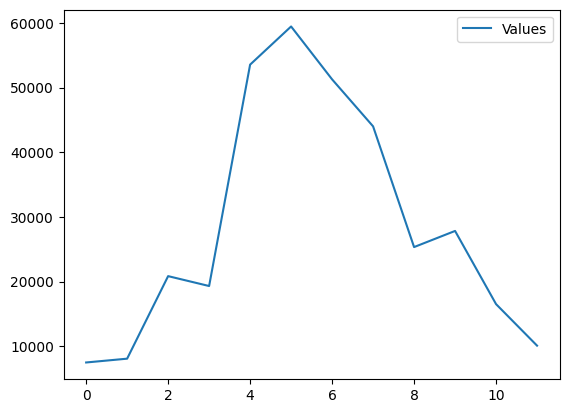

In [598]:
df.plot()

In [21]:
train_size = int(len(df)*0.7)

train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]

In [22]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10)
rmse = []
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

In [601]:
list(train.columns)

['Values']

In [602]:
len(train), len(test)

(11, 1)

In [23]:
def create_dataset(X, y, lag=1):
    xs,ys = [], []

    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])

    return np.array(xs), np.array(ys)

In [24]:
xtrain, ytrain = create_dataset(train, train.Values,1)
xtest, ytest = create_dataset(test, test.Values,1)

In [605]:
ytrain

array([ 8080, 20846, 19317, 53561, 59463, 51283, 44014, 25342, 27837,
       16517])

In [25]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler_y = StandardScaler()

# Reshape y_train to a 2D array and then fit and transform it
ytrain = ytrain.reshape(-1, 1)
ytrain = scaler_y.fit_transform(ytrain)

# Now, y_train_scaled contains the standardized values of y_train


In [26]:
ytrain

array([[-1.44384138],
       [-0.69292151],
       [-0.78286013],
       [ 1.23143564],
       [ 1.57860226],
       [ 1.09743944],
       [ 0.66986334],
       [-0.42845843],
       [-0.28169789],
       [-0.94756134]])

In [27]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2]), return_sequences=True))  # Return sequences for subsequent LSTM layers
model.add(LSTM(50, activation='relu', return_sequences=True))  # Add more LSTM layers
model.add(LSTM(50, activation='relu'))  # Add more LSTM layers
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")


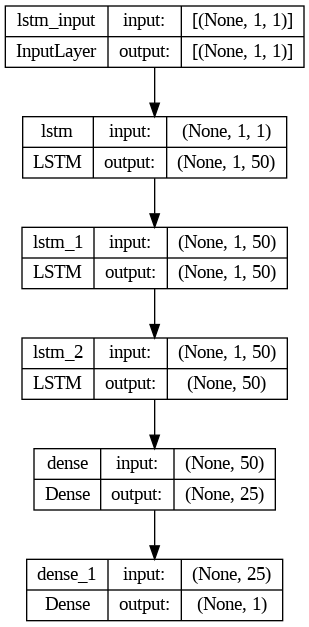

In [28]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

In [608]:
model.fit(xtrain, ytrain,
         epochs=200,
         batch_size=1,
         verbose=1,
         shuffle=False
         )

Epoch 1/200
10/10 [==============================] - 3s 4ms/step - loss: 4.4171
Epoch 2/200
10/10 [==============================] - 0s 5ms/step - loss: 4.8142
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 17.0844
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 68.8918
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 177.2063
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 59.3898
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 21.9198
Epoch 8/200
10/10 [==============================] - 0s 4ms/step - loss: 1.4753
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 3.6782
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 2.3698
Epoch 11/200
10/10 [==============================] - 0s 4ms/step - loss: 12.4666
Epoch 12/200
10/10 [==============================] - 0s 6ms/step - loss: 16.8188
Epoch 13/200
10/10 [=========

In [609]:
ypred = model.predict(xtrain)

1/1 [==============================] - 0s 394ms/step


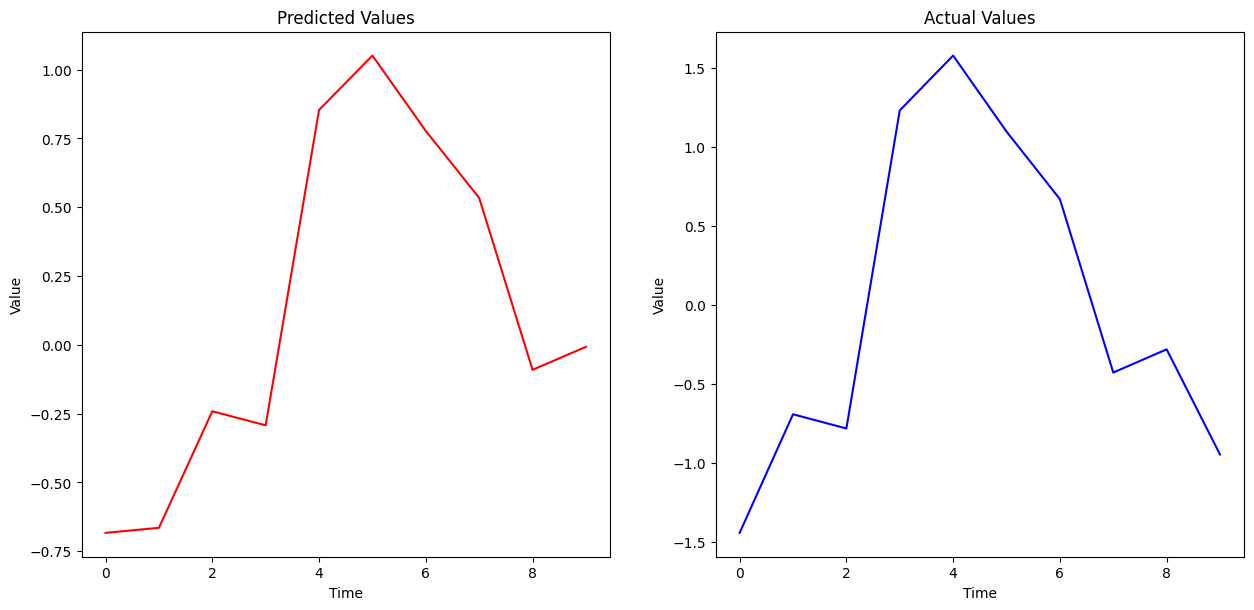

In [610]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(ypred, 'r', label="Predictions")
ax2.plot(ytrain, 'b', label="Actual")

ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.set_title("Predicted Values")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("Actual Values")

plt.show()


In [611]:
# Inverse transform the standardized y_train_scaled to obtain the original values
ypred = scaler_y.inverse_transform(ypred)


In [612]:
# Reshape y_train to its original form
ypred = ypred.reshape(-1)


In [613]:
# Inverse transform the standardized y_train_scaled to obtain the original values
ytrain = scaler_y.inverse_transform(ytrain)


In [614]:
# Reshape y_train to its original form
ytrain = ytrain.reshape(-1)


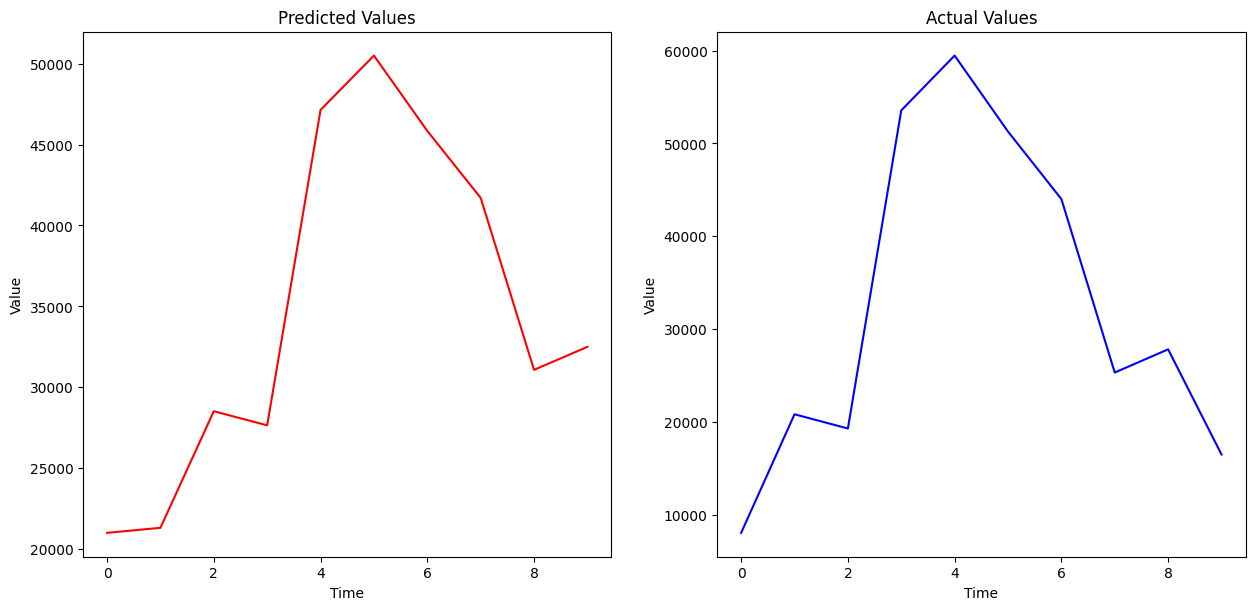

In [615]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(ypred, 'r', label="Predictions")
ax2.plot(ytrain, 'b', label="Actual")

ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.set_title("Predicted Values")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("Actual Values")

plt.show()
